In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from auxiliary import plot_boundary

sns.set()

# Arboles de decisión
**Dr. Facundo A. Lucianna - Aprendizaje Automático - CEIoT - FIUBA**

## Arboles de regresión

Para practicar el modelo de arbol de regresión, vamos a usar el dataset **Hitters**, el cual contiene datos de jugadores de beisbol de la liga estadounidense de 1986 y 1987. Contiene 322 observaciones con 20 datos. Este conjunto de datos se tomó de la biblioteca StatLib que se mantiene en la Universidad Carnegie Mellon. Los datos salariales fueron originalmente de Sports Illustrated, 20 de abril de 1987. Las estadísticas de 1986 y de carrera se obtuvieron de The 1987 Baseball Encyclopedia Update publicado por Collier Books, Macmillan Publishing Company, Nueva York.

Lo que queremos hacer es tener alguna regresión de los salarios de 1987 los jugadores usando como base los datos de ellos de su perfomance en 1986.

In [2]:
# Cargamos el dataset
df_hitters = pd.read_csv("./Hitters.csv")

In [3]:
df_hitters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [4]:
df_hitters.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


In [5]:
# Como los datos de salario no están completos, descartamos a aquellos jugadores que no tienen ese dato.
df_hitters.dropna(subset="Salary", inplace=True)

In [6]:
# Aplico feature engineering, modificando el target por el logaritmo
df_hitters["Salary_log"] = np.log(df_hitters["Salary"])

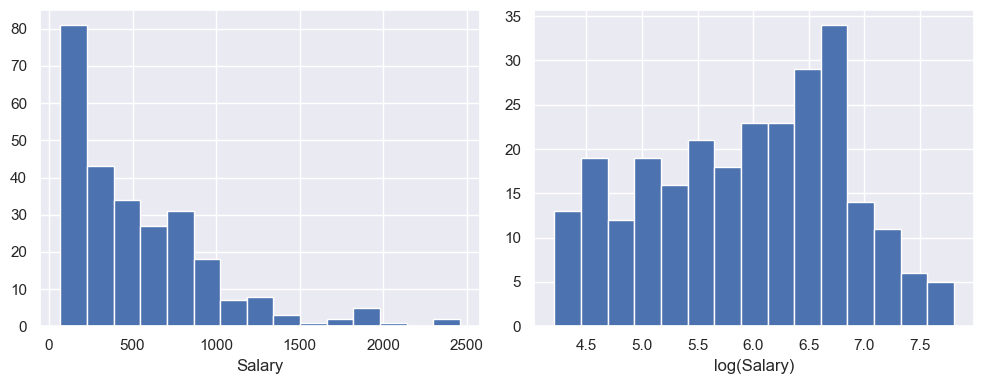

In [7]:
f, ax = plt.subplots(1,2, figsize=(10, 4))
df_hitters["Salary"].hist(ax=ax[0], bins=15)
df_hitters["Salary_log"].hist(ax=ax[1], bins=15)

ax[0].set_xlabel("Salary")
ax[1].set_xlabel("log(Salary)")
plt.tight_layout()

Como podemos ver, mejoramos la dispersion de datos, principalmente aquellos que estan en los primeros bins.

----

Trabajemos en el modelo

Empezamos separando los datos, para este ejemplo, solo voy a usar *Hits, Putouts, RBI, Runs, Walks y Years*. Que significa cada cosa está [explicado aqui](https://rdrr.io/cran/ISLR/man/Hitters.html)

In [8]:
# Para este ejemplo, solo voy a usar Years, RBI, PutOuts, Hits, Walks, Run como atributos. 
X = df_hitters.loc[:, ["Hits", "PutOuts", "RBI", "Runs", "Walks", "Years"]]
# Y como variable a predecir a Salary_log
y = df_hitters.loc[:, "Salary_log"]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 42)

Ahora vamos a aplicar el procedimiento que vimos, primero llamamos al modelo de [arbol de regresion](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [10]:
from sklearn.tree import DecisionTreeRegressor

In [11]:
# Creamos el arbol
regression = DecisionTreeRegressor(criterion='squared_error', splitter='best', 
                                   max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                   random_state=42)
# Y entrenamos
regression.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

Podemos  ver cuales son los parametros de creacion de mi modelo (esto sale en la documentacion misma y es comun a todos los modelos) usando ".get_params()".

In [12]:
regression.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

Podemos ver a nuestro arbol para entender que hizo usando [export_graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html)

In [13]:
from sklearn.tree import export_graphviz
export_graphviz(regression, out_file = "arbol_regresion.dot",
                feature_names=["Hits", "PutOuts", "RBI", "Runs", "Walks", "Years"],
                rounded=True,
                filled=True)

Podemos ver nuestro arbol en [webgraphviz](http://www.webgraphviz.com/?tab=map). Esta pagina nos mostrara la disposicion de nuestros nodos y como el algoritmo fue tomando desicion de las diferentes divisiones.

Es por esto que prefiero usar la herramienta web, se puede trabajar, para mejorar la gráfica:

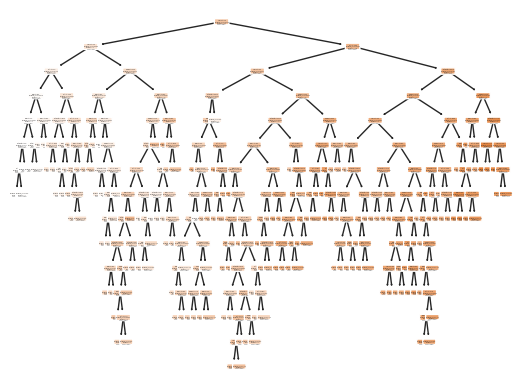

In [14]:
from sklearn.tree import plot_tree
plot_tree(regression, filled=True, feature_names=["Hits", "PutOuts", "RBI", "Runs", "Walks", "Years"], rounded=True);

Midamos como este modelo performa usando el error medio absoluto:

In [15]:
from sklearn.metrics import mean_absolute_error

y_pred_train = regression.predict(X_train)
y_pred = regression.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae = mean_absolute_error(y_test, y_pred)

print(f"El error de entreamiento fue: {mae_train}")
print(f"El error de testeo fue: {mae}")

El error de entreamiento fue: 0.0
El error de testeo fue: 0.4601579497699184


Este resultado es muy malo, si el entrenamiento es cero, es seguro que hay overfitting (esto lo esperabamos, por elegimos que las hojas tengan una sola muestra). Pero comparemos con algun modelo, rapidamente para tener alguna referencia

In [16]:
from sklearn.linear_model import LinearRegression
regresion_lineal = LinearRegression()
regresion_lineal.fit(X_train, y_train)

y_pred_lineal = regresion_lineal.predict(X_test)

print(f"El error de testeo fue: {mean_absolute_error(y_test, y_pred_lineal)}")

El error de testeo fue: 0.5276951139451312


Asi y todo, performo mejor que el modelo de regresión lineal, pero no por mucho.

----

Ahora intentemos encontrar un arbol que tenga menos overfitting usando validación cruzada con 5 folds.

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
model = DecisionTreeRegressor()

param_grid = {
    'criterion': ["squared_error", "absolute_error"],
    'max_depth': range(2, 6),
    'min_samples_split': range(2, 10),
    'max_features': [None, "sqrt", "log2"]
}

grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1)

grid.fit(X_train, y_train)
print(f"Los mejores parámetros del modelo encontrado es: {grid.best_params_}")
print(f"El MAE medio de la validación cruzada de la mejor combinación es: {(-1)*grid.best_score_}")

Los mejores parámetros del modelo encontrado es: {'criterion': 'absolute_error', 'max_depth': 2, 'max_features': None, 'min_samples_split': 2}
El MAE medio de la validación cruzada de la mejor combinación es: 0.4264771028501323


Con los hiper-parámetros encontrados, veamos el resultado obtenido:

In [19]:
# Creamos el arbol
regression = DecisionTreeRegressor(**grid.best_params_)

# Y entrenamos
regression.fit(X_train, y_train)

y_pred_train = regression.predict(X_train)
y_pred = regression.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae = mean_absolute_error(y_test, y_pred)

print(f"El error de entreamiento fue: {mae_train}")
print(f"El error de testeo fue: {mae}")

El error de entreamiento fue: 0.3891094530879875
El error de testeo fue: 0.46362833333966574


El modelo no mejoro, pero es mucho mas general y tiene pocas ramas. Si lo vemos, nos damos cuenta que es el modelo que arrancamos la clase.

In [20]:
export_graphviz(regression, out_file = "arbol_regresion_best_param.dot",
                feature_names=["Hits", "PutOuts", "RBI", "Runs", "Walks", "Years"],
                rounded=True,
                filled=True)

Un beneficio es que este modelo es mucho más sencillo e interpretable.


---
## Arboles de clasificación

Para practicar el modelo de arbol de clasificación, vamos a usar el dataset [**Heart**](https://archive.ics.uci.edu/dataset/45/heart+disease), el cual mediciones de 302 pacientes, con 13 atributos de variables fisiologicas. Además contamos con una columna de valores binarios llamada **target** que nos indica si el paciente tiene una enfermedad coronaria o no.

In [21]:
# Cargamos el dataset
df_heart = pd.read_csv("./Heart.csv")

# Por algún motivo este dataset tiene duplicadas muchas veces las mismas filas
df_heart.drop_duplicates(inplace=True)

In [22]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 878
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trestbps  302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalach   302 non-null    int64  
 8   exang     302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    int64  
 11  ca        302 non-null    int64  
 12  thal      302 non-null    int64  
 13  target    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


In [23]:
df_heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Las clases están bastante balanceadas, voy a usar F1-Score como metrica de evaluación

In [24]:
df_heart.target.value_counts()

target
1    164
0    138
Name: count, dtype: int64

---
Trabajemos en el modelo

Para este caso vamos a usar todos los atributos. Una ventaja del modelo de arbol es que no nos afecta el tipo de variable, podes usar variables categoricas sin problemas.

In [25]:
X = df_heart.iloc[:, :-1]
y = df_heart.iloc[:, -1]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Ahora vamos a aplicar el modelo, primero llamamos al modelo de [arbol de clasificación](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [27]:
from sklearn.tree import DecisionTreeClassifier

# Creamos el arbol
classification = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                        random_state=42)
# Y entrenamos
classification.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Podemos ver a nuestro arbol para entender que hizo usando export_graphviz

In [28]:
export_graphviz(classification, out_file = "arbol_clasificacion.dot",
                feature_names=df_heart.columns[:-1],
                class_names=["No tiene enfermedad cardiaca", "Tiene enfermedad cardiaca"],
                rounded=True,
                filled=True)

Midamos como este modelo performa usando el F1-score:

In [29]:
from sklearn.metrics import f1_score

y_pred_train = classification.predict(X_train)
y_pred = classification.predict(X_test)

f1_train = f1_score(y_train, y_pred_train)
f1 = f1_score(y_test, y_pred)

print(f"F1-score de entreamiento fue: {f1_train}")
print(f"F1-score de testeo fue: {f1}")

F1-score de entreamiento fue: 1.0
F1-score de testeo fue: 0.7228915662650602


El modelo predijo bastante bien el set de testeo. Busquemos los hiper-parámetros usando búsqueda de grilla:

In [30]:
model = DecisionTreeClassifier()

param_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': range(20, 30),
    'min_samples_split': range(10, 20),
    'min_samples_leaf': range(10, 20)
}

grid = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)

grid.fit(X_train, y_train)
print(f"Los mejores parámetros del modelo encontrado es: {grid.best_params_}")
print(f"El F1 medio de la validación cruzada de la mejor combinación es: {grid.best_score_}")

Los mejores parámetros del modelo encontrado es: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 13, 'min_samples_split': 10}
El F1 medio de la validación cruzada de la mejor combinación es: 0.8242541638586693


In [31]:
# Creamos el arbol
classification = DecisionTreeClassifier(**grid.best_params_)
# Y entrenamos
classification.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=13,
                       min_samples_split=10)

In [32]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

y_pred = classification.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"La exactitud de clasificación es: {accuracy}")
print(f"F1-score de testeo fue: {f1}")
print(f"Precisión de testeo fue: {precision}")
print(f"Recall de testeo fue: {recall}")

La exactitud de clasificación es: 0.7802197802197802
F1-score de testeo fue: 0.7619047619047619
Precisión de testeo fue: 0.7804878048780488
Recall de testeo fue: 0.7441860465116279


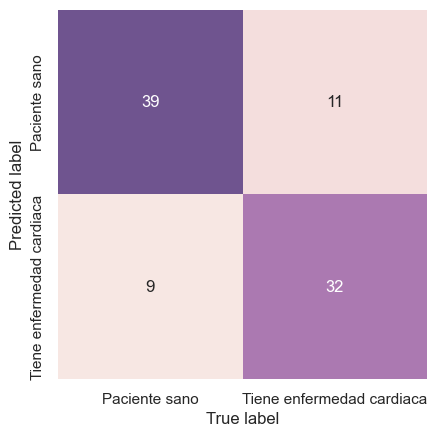

In [33]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["Paciente sano", "Tiene enfermedad cardiaca"],
            yticklabels=["Paciente sano", "Tiene enfermedad cardiaca"],
            cmap=sns.cubehelix_palette(as_cmap=True, gamma=.5))
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [34]:
export_graphviz(classification, out_file = "arbol_clasificacion_best.dot",
                feature_names=df_heart.columns[:-1],
                class_names=["Paciente sano", "Tiene enfermedad cardiaca"],
                rounded=True,
                filled=True)

Veamos un modelo dos dimensional para ver como es la región de clasificación de un modelo

In [35]:
X = df_heart.loc[:, ["age", "trestbps"]].values
y = df_heart.iloc[:, -1].values

# Creamos el arbol
classification = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Y entrenamos
classification.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=42)

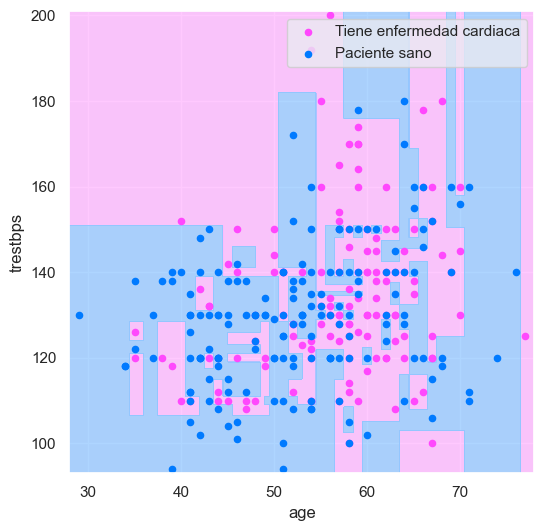

In [36]:
plot_boundary(X, y, classification, 
              step_x=(0.01, 0.01),
              max_x=(1, 1),
              min_x=(-1, -1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(6, 6),
              legend=True,
              label_point=("Tiene enfermedad cardiaca", "Paciente sano"),
              point_size=20,
              labels_axis=("age", "trestbps"))

---
## Bosques aleatorios

Por ultimo vamos a utilizar un ejemplo de bosque aleatorio. Con estos bosques podemos usar casos de [clasificación](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier), como asi tambien de [regresión](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Ahora vamos a hacer un ejemplo de regresión, pero el procedimiento de clasificación es similar.

In [37]:
# Cargamos el dataset
df_hitters = pd.read_csv("./Hitters.csv")

# Como los datos de salario no están completos, descartamos a aquellos jugadores que no tienen ese dato.
df_hitters.dropna(subset="Salary", inplace=True)

# Aplico feature engineering, modificando el target por el logaritmo
df_hitters["Salary_log"] = np.log(df_hitters["Salary"])

df_hitters.drop(columns="Salary", inplace=True)

In [38]:
X = df_hitters.iloc[:, :-1].values
# Y como variable a predecir a Salary_log
y = df_hitters.iloc[:, -1].values

# Para este ejemplo, solo voy a usar Years, RBI, PutOuts, Hits, Walks, Run como atributos. 
X = df_hitters.loc[:, ["Hits", "PutOuts", "RBI", "Runs", "Walks", "Years"]].values
# Y como variable a predecir a Salary_log
y = df_hitters.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

Para este ejemplo, no vamos a tocar mucho los parametros, se usaran 100 arboles aleatorios usando bagging y seccionando a los atributos de entrada

In [39]:
# importamos RandomForestRegressor de los metodos de ensamble de sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor

regression = RandomForestRegressor(random_state = 42)
regression.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [40]:
y_pred_train = regression.predict(X_train)
y_pred = regression.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae = mean_absolute_error(y_test, y_pred)

print(f"El error de entreamiento fue: {mae_train}")
print(f"El error de testeo fue: {mae}")

El error de entreamiento fue: 0.14293432357666222
El error de testeo fue: 0.34635736375692855


Aqui vemos como mejoramos el modelo al trabajar con un bosque en vez de un solo arbol.

----
## XGBoost

XGBoost es una implementación avanzada de Boosting, que utiliza árboles de decisión como modelos base y emplea técnicas como la regularización y la poda para mejorar aún más la capacidad de generalización del modelo y la eficiencia computacional. XGBoost se ha convertido en una opción popular debido a su rendimiento superior en una variedad de problemas.

Para ello debemos instalar la libreria [XGBoost](https://xgboost.readthedocs.io/en/stable/), usando el gestor de paquetes de preferencia, tales como:

```bash
conda install conda-forge::xgboost
``` 

```bash
pip install xgboost
``` 

```bash
poetry add xgboost
```

Veamos como se comporta con el dataset de enfermedades cardíacas:

In [41]:
df_heart = pd.read_csv("./Heart.csv")
df_heart.drop_duplicates(inplace=True)

X = df_heart.iloc[:, :-1]
y = df_heart.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [42]:
import xgboost as xgb

In [43]:
# Inicializamos XGBoost con 1000 estimadores
xgb_classifier = xgb.XGBClassifier(random_state=42, n_jobs=-1, n_estimators=1000)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [44]:
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"La exactitud de clasificación es: {accuracy}")
print(f"F1-score de testeo fue: {f1}")
print(f"Precisión de testeo fue: {precision}")
print(f"Recall de testeo fue: {recall}")

La exactitud de clasificación es: 0.8131868131868132
F1-score de testeo fue: 0.8172043010752689
Precisión de testeo fue: 0.76
Recall de testeo fue: 0.8837209302325582


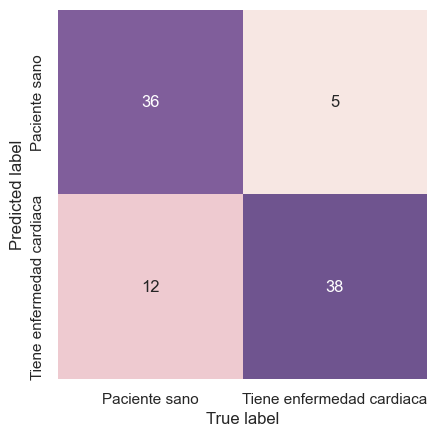

In [45]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["Paciente sano", "Tiene enfermedad cardiaca"],
            yticklabels=["Paciente sano", "Tiene enfermedad cardiaca"],
            cmap=sns.cubehelix_palette(as_cmap=True, gamma=.5))
plt.xlabel('True label')
plt.ylabel('Predicted label');

Vemos que mejora con respecto al mejor árbol. Se deja al alumno explorar los hiper-parámetros, los cuales son muchísimos y no son triviales definir, o limitar para una búsqueda de hiper-parámetros.

Veamos la frontera para este modelo:

In [46]:
X = df_heart.loc[:, ["age", "trestbps"]].values
y = df_heart.iloc[:, -1].values

xgb_classifier = xgb.XGBClassifier(random_state=42, n_jobs=-1)
xgb_classifier.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

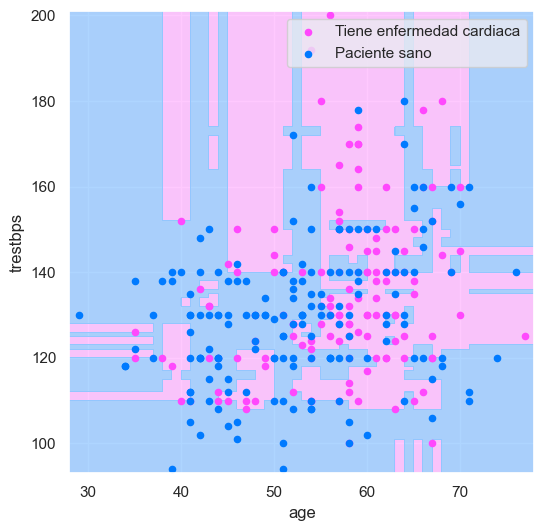

In [47]:
plot_boundary(X, y, xgb_classifier, 
              step_x=(0.01, 0.01),
              max_x=(1, 1),
              min_x=(-1, -1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(6, 6),
              legend=True,
              label_point=("Tiene enfermedad cardiaca", "Paciente sano"),
              point_size=20,
              labels_axis=("age", "trestbps"))